# Brain Stroke Detection from CT Scans using Deep Learning

## Project Introduction

This project aims to develop a deep learning-based system for the automatic detection of strokes in brain CT scans. Stroke is a medical emergency that requires immediate treatment to minimize brain damage and other complications. Early and accurate detection is crucial for improving patient outcomes.

### Approach
We will use an ensemble of three Convolutional Neural Networks (CNNs) pretrained on ImageNet:
1. **DenseNet121** - Known for its dense connections that help with feature reuse and gradient flow
2. **ResNet50** - Famous for its residual connections that solve the vanishing gradient problem
3. **EfficientNet B3** - A model that uses compound scaling to balance network depth, width, and resolution

Each model will be fine-tuned on our brain CT scan dataset. We then use an ensemble approach by averaging the predictions from all three models to make the final classification decision.

### Dataset
The dataset contains brain CT scan images organized into two classes:
- **Normal**: CT scans of normal brains
- **Stroke**: CT scans showing evidence of stroke

The dataset is already split into Train, Validation, and Test sets.

### Visualization
For the detected stroke cases, we will use Gradient-weighted Class Activation Mapping (Grad-CAM) to highlight the areas of the brain that influenced the model's decision, providing an interpretable visual explanation.

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import logging
import pickle
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import random
import time
import timm
import pandas as pd
import seaborn as sns

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("cnn_models_pytorch.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    logger.info(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    logger.info("Using CPU")

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
np.random.seed(42)
random.seed(42)

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-27 17:29:16,507 - __main__ - INFO - Using GPU: NVIDIA GeForce RTX 3050 Laptop GPU


## Dataset Definition

First, we'll define our custom dataset class for brain CT scan images.

In [2]:
class BrainCTDataset(Dataset):
    """Custom Dataset for loading brain CT scan images"""
    def __init__(self, directory, transform=None):
        """
        Args:
            directory: Directory with all the images organized in class folders
            transform: Optional transform to be applied on a sample
        """
        self.directory = directory
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(directory, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(class_dir, img_name)
                    self.samples.append((img_path, self.class_to_idx[class_name]))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        try:
            # Use PIL Image for compatibility with torchvision transforms
            image = Image.open(img_path).convert('RGB')
            
            if self.transform:
                image = self.transform(image)
            
            return image, label
        except Exception as e:
            logger.error(f"Error loading image {img_path}: {str(e)}")
            # Return a black image and the label on error
            if self.transform:
                default_img = torch.zeros((3, 256, 256))
            else:
                default_img = Image.new('RGB', (256, 256), (0, 0, 0))
                if self.transform:
                    default_img = self.transform(default_img)
            return default_img, label

## Data Visualization and Exploration

Let's explore our dataset to understand its characteristics.

Dataset Distribution:
        Train  Validation  Test
Normal   1087         157   307
Stroke    756          78   130


<Figure size 1200x600 with 0 Axes>

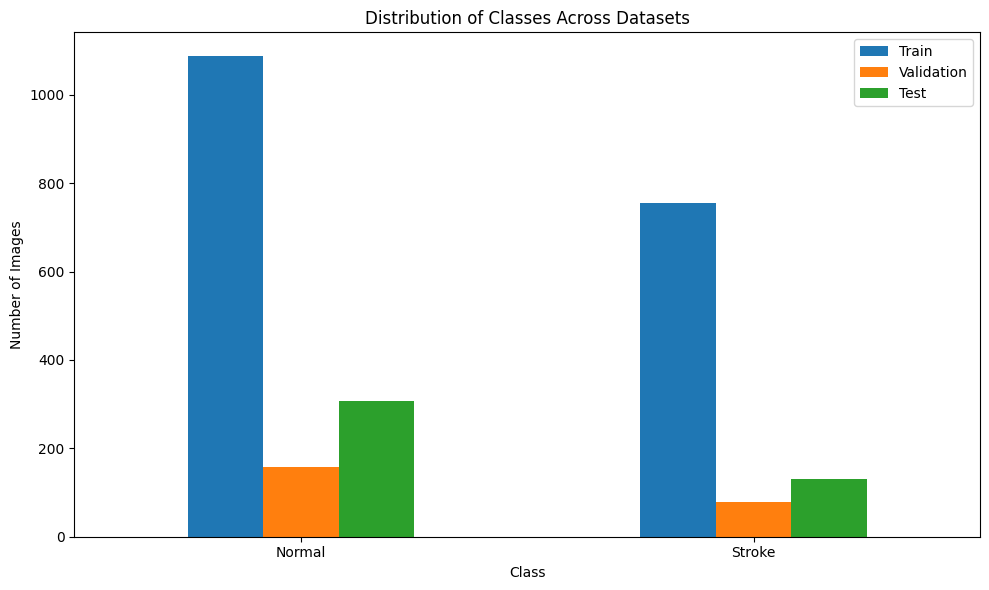

In [3]:
# Define the dataset directories
base_dir = 'Brain_Stroke_CT-SCAN_image'
train_dir = os.path.join(base_dir, 'Train')
valid_dir = os.path.join(base_dir, 'Validation')
test_dir = os.path.join(base_dir, 'Test')
models_dir = 'models_pytorch'

# Create models directory if it doesn't exist
os.makedirs(models_dir, exist_ok=True)

# Function to count images by class
def count_images(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            count = len([f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            class_counts[class_name] = count
    return class_counts

# Count the number of images in each dataset split and class
train_counts = count_images(train_dir)
valid_counts = count_images(valid_dir)
test_counts = count_images(test_dir)

# Create a DataFrame for easier visualization
counts_df = pd.DataFrame({
    'Train': train_counts,
    'Validation': valid_counts,
    'Test': test_counts
})

print("Dataset Distribution:")
print(counts_df)

# Visualize dataset distribution
plt.figure(figsize=(12, 6))
counts_df.plot(kind='bar', figsize=(10, 6))
plt.title('Distribution of Classes Across Datasets')
plt.ylabel('Number of Images')
plt.xlabel('Class')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Sample Training Images:


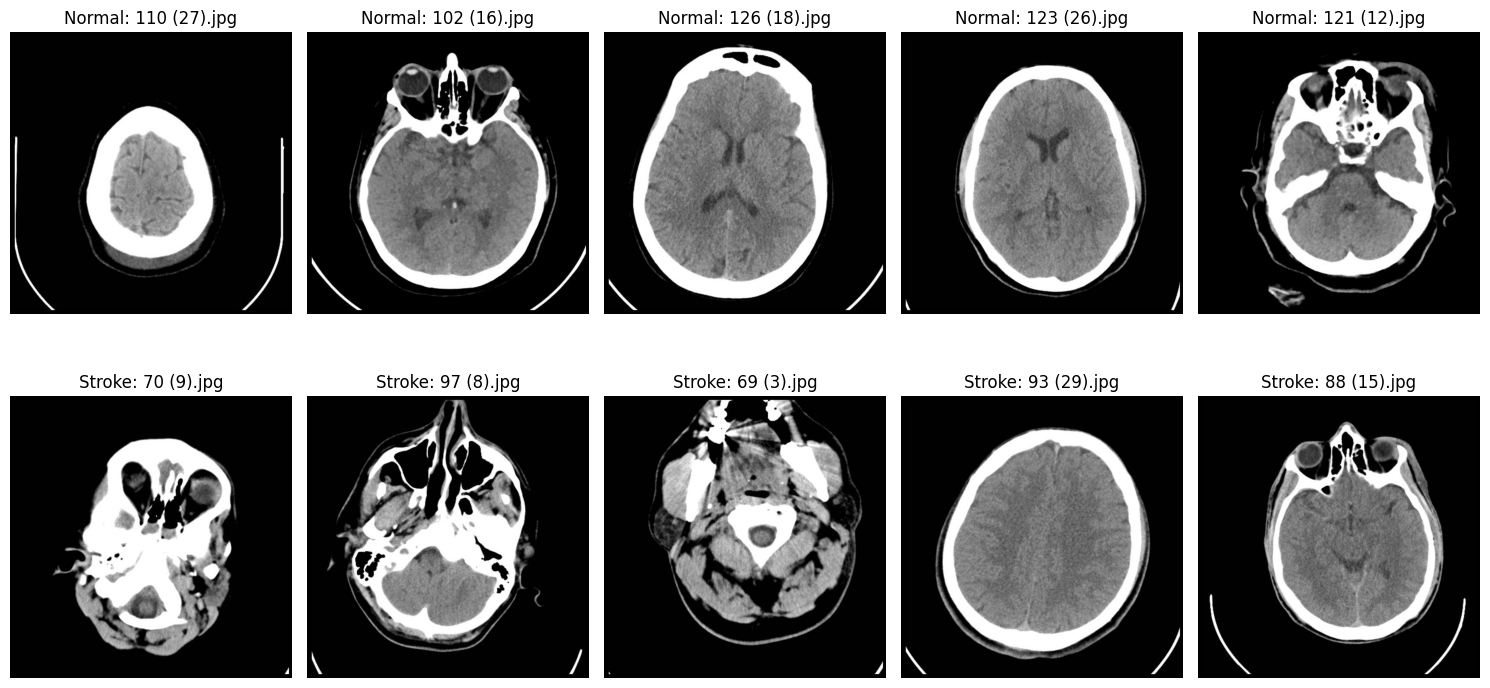


Image Statistics:
avg_width: 650.00
avg_height: 650.00
min_width: 650.00
min_height: 650.00
max_width: 650.00
max_height: 650.00
avg_aspect_ratio: 1.00


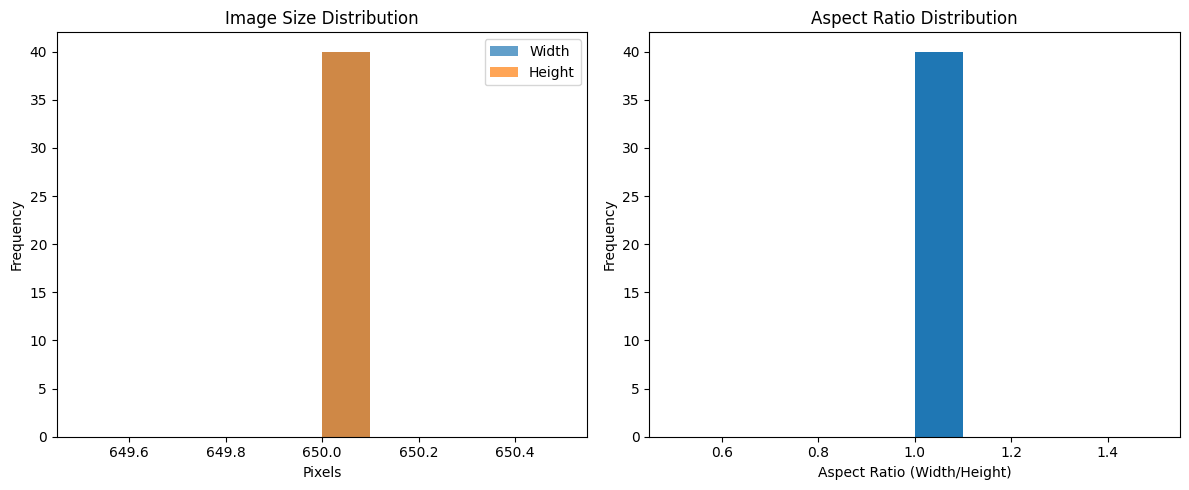

In [4]:
# Visualize some sample images from each class
def display_samples(directory, num_samples=5):
    """Display sample images from each class"""
    classes = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    
    plt.figure(figsize=(15, 8))
    for i, class_name in enumerate(classes):
        class_dir = os.path.join(directory, class_name)
        images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        samples = random.sample(images, min(num_samples, len(images)))
        
        for j, img_name in enumerate(samples):
            img_path = os.path.join(class_dir, img_name)
            img = Image.open(img_path).convert('RGB')
            
            plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.title(f"{class_name}: {img_name}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display sample images from training set
print("Sample Training Images:")
display_samples(train_dir, num_samples=5)

# Let's also check the image size of a random sample
def check_image_stats(directory, num_samples=20):
    """Check image dimensions and aspect ratios"""
    classes = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    img_sizes = []
    aspect_ratios = []
    
    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        samples = random.sample(images, min(num_samples, len(images)))
        
        for img_name in samples:
            img_path = os.path.join(class_dir, img_name)
            img = Image.open(img_path)
            width, height = img.size
            img_sizes.append((width, height))
            aspect_ratios.append(width / height)
    
    # Calculate statistics
    widths = [w for w, h in img_sizes]
    heights = [h for w, h in img_sizes]
    
    stats = {
        'avg_width': np.mean(widths),
        'avg_height': np.mean(heights),
        'min_width': min(widths),
        'min_height': min(heights),
        'max_width': max(widths),
        'max_height': max(heights),
        'avg_aspect_ratio': np.mean(aspect_ratios)
    }
    
    print("\nImage Statistics:")
    for k, v in stats.items():
        print(f"{k}: {v:.2f}")
    
    # Plot size distribution
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=10, alpha=0.7, label='Width')
    plt.hist(heights, bins=10, alpha=0.7, label='Height')
    plt.xlabel('Pixels')
    plt.ylabel('Frequency')
    plt.title('Image Size Distribution')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.hist(aspect_ratios, bins=10)
    plt.xlabel('Aspect Ratio (Width/Height)')
    plt.ylabel('Frequency')
    plt.title('Aspect Ratio Distribution')
    
    plt.tight_layout()
    plt.show()

# Check image statistics
check_image_stats(train_dir)

## Model Definition and Training Utilities

Now, let's define our model architecture and training utilities.

In [5]:
class StrokeCTModel(nn.Module):
    """CNN model for stroke detection"""
    def __init__(self, base_model_name, input_shape=(256, 256, 3), num_classes=2):
        super(StrokeCTModel, self).__init__()
        self.model_name = base_model_name.lower()
        
        # Initialize the base model
        if self.model_name == 'densenet121':
            self.base_model = models.densenet121(pretrained=True)
            num_features = self.base_model.classifier.in_features
            self.base_model.classifier = nn.Identity()
            
        elif self.model_name == 'resnet50':
            self.base_model = models.resnet50(pretrained=True)
            num_features = self.base_model.fc.in_features
            self.base_model.fc = nn.Identity()
            
        elif self.model_name == 'efficientnet':
            # Use timm for efficientnet models (more reliable)
            import timm
            # Use EfficientNet-B3 for better balance of performance and size
            self.base_model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=0)
            num_features = self.base_model.num_features
            
        elif self.model_name == 'xception':
            # Use timm for a REAL Xception model instead of ResNet50 substitute
            import timm
            self.base_model = timm.create_model('xception', pretrained=True, num_classes=0)
            num_features = self.base_model.num_features
            logger.info(f"Using real Xception model from timm with {num_features} features")
            
        else:
            raise ValueError(f"Unknown base model: {base_model_name}")
        
        # Add custom layers
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )
    
    def forward(self, x):
        features = self.base_model(x)
        return self.classifier(features)

def create_model(base_model_name, input_shape=(256, 256, 3), num_classes=2):
    """
    Create a CNN model using a pre-trained base model
    """
    logger.info(f"Creating {base_model_name} model...")
    model = StrokeCTModel(base_model_name, input_shape, num_classes)
    model = model.to(device)
    return model

def get_transforms(is_training=False):
    """Get image transformations for training and testing"""
    # Normalization values for ImageNet
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    
    if is_training:
        # Data augmentation for training
        return transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(20),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2)),
            transforms.ToTensor(),
            normalize
        ])
    else:
        # Only resize and normalize for validation/testing
        return transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            normalize
        ])

## Training Function

We'll define a function to train our models. We'll train each model for 50 epochs instead of the original 30 epochs.

In [6]:
def train_model(model, train_dir, valid_dir, model_name, input_shape=(256, 256), batch_size=8, epochs=50):
    """
    Train a CNN model on the dataset and save it after training
    
    Parameters:
    -----------
    model : nn.Module
        The PyTorch model to train
    train_dir : str
        Path to the training directory
    valid_dir : str
        Path to the validation directory
    model_name : str
        Name of the model for saving
    input_shape : tuple
        Input shape for images (width, height)
    batch_size : int
        Batch size for training
    epochs : int
        Number of epochs to train
        
    Returns:
    --------
    tuple
        The trained model and training history
    """
    # Create datasets and data loaders
    train_transform = get_transforms(is_training=True)
    valid_transform = get_transforms(is_training=False)
    
    train_dataset = BrainCTDataset(train_dir, transform=train_transform)
    valid_dataset = BrainCTDataset(valid_dir, transform=valid_transform)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=0, 
        pin_memory=False
    )
    
    valid_loader = DataLoader(
        valid_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=0, 
        pin_memory=False
    )
    
    logger.info(f"Training samples: {len(train_dataset)}")
    logger.info(f"Validation samples: {len(valid_dataset)}")
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # Training loop
    start_time = time.time()
    best_val_acc = 0.0
    
    for epoch in range(epochs):
        epoch_start = time.time()
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            # Update progress bar
            train_bar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'acc': f"{train_correct/train_total:.4f}"
            })
        
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            val_bar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{epochs} [Valid]")
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Statistics
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                # Update progress bar
                val_bar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'acc': f"{val_correct/val_total:.4f}"
                })
        
        val_loss = val_loss / len(valid_loader.dataset)
        val_acc = val_correct / val_total
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Calculate epoch time
        epoch_time = time.time() - epoch_start
        
        # Print epoch statistics
        logger.info(f"Epoch {epoch+1}/{epochs} - "
                    f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                    f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} - "
                    f"Time: {epoch_time:.2f}s")
        
        # Save the best model only (not per epoch)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_path = os.path.join(models_dir, f"stroke_{model_name}_best.pkl")
            
            # Save model to CPU before pickling
            model_cpu = model.cpu()
            with open(best_model_path, 'wb') as f:
                pickle.dump(model_cpu, f)
                
            # Move model back to device
            model = model.to(device)
            logger.info(f"Best model saved to {best_model_path} with validation accuracy: {best_val_acc:.4f}")
    
    # Calculate total training time
    total_time = time.time() - start_time
    logger.info(f"Training completed in {total_time:.2f}s")
    
    # Save final model (single general pkl)
    final_model_path = os.path.join(models_dir, f"stroke_{model_name}.pkl")
    
    # Save model to CPU before pickling
    model_cpu = model.cpu()
    with open(final_model_path, 'wb') as f:
        pickle.dump(model_cpu, f)
        
    # Move model back to device for any further operations
    model = model.to(device)
    logger.info(f"Final model saved to {final_model_path}")
    
    # Save training history
    history_path = os.path.join(models_dir, f"{model_name}_history.pkl")
    with open(history_path, 'wb') as f:
        pickle.dump(history, f)
    logger.info(f"Training history saved to {history_path}")
    
    # Plot and save training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title(f'{model_name.upper()} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title(f'{model_name.upper()} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(models_dir, f"{model_name}_history.png"))
    plt.show()
    
    return model, history

## Training Models

We'll train each model separately with 50 epochs. You can run one model at a time and come back later to run the next model.

In [7]:
def train_densenet121():
    """Train DenseNet121 model for stroke detection"""
    logger.info("Training DENSENET121 model...")
    model = create_model('densenet121')
    model, history = train_model(model, train_dir, valid_dir, 'densenet121', epochs=50)
    return model, history

# Uncomment to train DenseNet121
# densenet_model, densenet_history = train_densenet121()

In [8]:
def train_resnet50():
    """Train ResNet50 model for stroke detection"""
    logger.info("Training RESNET50 model...")
    model = create_model('resnet50')
    model, history = train_model(model, train_dir, valid_dir, 'resnet50', epochs=50)
    return model, history

# Uncomment to train ResNet50
# resnet_model, resnet_history = train_resnet50()

In [9]:
def train_efficientnet():
    """Train EfficientNet model for stroke detection"""
    logger.info("Training EFFICIENTNET model...")
    model = create_model('efficientnet')
    model, history = train_model(model, train_dir, valid_dir, 'efficientnet', epochs=50)
    return model, history

# Uncomment to train EfficientNet
# efficientnet_model, efficientnet_history = train_efficientnet()

In [ ]:
def train_xception():
    """Train true Xception model (using timm) for stroke detection"""
    logger.info("Training XCEPTION model...")
    model = create_model('xception')
    model, history = train_model(model, train_dir, valid_dir, 'xception', epochs=50)
    
    return model, history

# Uncomment to train Xception
xception_model, xception_history = train_xception()

2025-04-27 17:29:19,347 - __main__ - INFO - Training XCEPTION model...
2025-04-27 17:29:19,350 - __main__ - INFO - Creating xception model...
c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\timm\models\_factory.py:114: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
2025-04-27 17:29:19,744 - timm.models._builder - INFO - Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth)
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to C:\Users\admin/.cache\torch\hub\checkpoints\xception-43020ad28.pth


KeyboardInterrupt: 

## Model Evaluation

We'll implement functions to evaluate our models on the test set.

In [ ]:
def load_model(model_name):
    """Load a trained model from disk"""
    model_path = os.path.join(models_dir, f"stroke_{model_name}.pkl")
    if os.path.exists(model_path):
        logger.info(f"Loading {model_name} model from {model_path}")
        try:
            with open(model_path, 'rb') as f:
                model = pickle.load(f).to(device)
            model.eval()
            logger.info(f"Successfully loaded {model_name} model")
            return model
        except Exception as e:
            logger.error(f"Error loading {model_name} model: {str(e)}")
            return None
    else:
        logger.error(f"Model file not found: {model_path}")
        return None
    
def evaluate_model(model, test_dir, input_shape=(256, 256), batch_size=32):
    """Evaluate a model on the test set"""
    # Create dataset and data loader
    test_transform = get_transforms(is_training=False)
    test_dataset = BrainCTDataset(test_dir, transform=test_transform)
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=0,
        pin_memory=False
    )
    
    logger.info(f"Test samples: {len(test_dataset)}")
    
    # Set model to evaluation mode
    model.eval()
    
    # Initialize variables
    test_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []
    
    # Loss function
    criterion = nn.CrossEntropyLoss()
    
    # Evaluate the model
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Get predictions and probabilities
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            # Save predictions, probabilities, and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            
            # Update loss
            test_loss += loss.item() * inputs.size(0)
    
    # Calculate average loss
    test_loss = test_loss / len(test_loader.dataset)
    
    # Calculate accuracy
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    
    # Create result dictionary
    result = {
        'loss': test_loss,
        'accuracy': accuracy,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }
    
    # Calculate confusion matrix and classification report
    cm = confusion_matrix(all_labels, all_preds)
    class_names = test_dataset.classes
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    
    result['confusion_matrix'] = cm
    result['classification_report'] = report
    
    return result

def visualize_evaluation(result, model_name):
    """Visualize evaluation results"""
    # Print evaluation metrics
    print(f"Model: {model_name.upper()}")
    
    # Print loss if available (for individual models)
    if 'loss' in result:
        print(f"Test Loss: {result['loss']:.4f}")
    else:
        print(f"Test Loss: N/A (not calculated for ensemble)")
    
    print(f"Test Accuracy: {result['accuracy']:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    report_df = pd.DataFrame(result['classification_report']).transpose()
    print(report_df)
    
    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    cm = result['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Stroke'], 
                yticklabels=['Normal', 'Stroke'])
    plt.title(f'Confusion Matrix - {model_name.upper()}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

In [ ]:
# Evaluate each model
models = ['densenet121', 'resnet50', 'efficientnet', 'xception']
evaluation_results = {}

for model_name in models:
    model = load_model(model_name)
    if model is not None:
        result = evaluate_model(model, test_dir)
        evaluation_results[model_name] = result
        visualize_evaluation(result, model_name)

## Ensemble Model Evaluation

Let's evaluate the performance of the ensemble model.

In [ ]:
def evaluate_ensemble(evaluation_results, test_dir):
    """Evaluate the ensemble of models"""
    # Ensure we have results for all models
    models = ['densenet121', 'resnet50', 'efficientnet']
    available_models = [model for model in models if model in evaluation_results]
    
    if not available_models:
        logger.error("No model evaluation results available.")
        return None
    
    # Get the test dataset labels
    test_transform = get_transforms(is_training=False)
    test_dataset = BrainCTDataset(test_dir, transform=test_transform)
    
    # Get a reference model for labels
    ref_model = available_models[0]
    
    # Combine predictions from all models
    ensemble_probs = np.zeros((len(evaluation_results[ref_model]['labels']), 2))
    for model_name in available_models:
        ensemble_probs += np.array(evaluation_results[model_name]['probabilities'])
    
    # Average the probabilities
    ensemble_probs /= len(available_models)
    
    # Get the predicted classes
    ensemble_preds = np.argmax(ensemble_probs, axis=1)
    true_labels = evaluation_results[ref_model]['labels']
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, ensemble_preds)
    
    # Calculate confusion matrix and classification report
    cm = confusion_matrix(true_labels, ensemble_preds)
    class_names = test_dataset.classes
    report = classification_report(true_labels, ensemble_preds, target_names=class_names, output_dict=True)
    
    # Create result dictionary
    result = {
        'accuracy': accuracy,
        'predictions': ensemble_preds,
        'labels': true_labels,
        'probabilities': ensemble_probs,
        'confusion_matrix': cm,
        'classification_report': report
    }
    
    return result

# Evaluate the ensemble model
ensemble_result = evaluate_ensemble(evaluation_results, test_dir)
if ensemble_result is not None:
    visualize_evaluation(ensemble_result, 'ensemble')

## Model Explanation with Grad-CAM

Now, let's implement Grad-CAM for model interpretability.

In [ ]:
class GradCAM:
    """Class for generating Grad-CAM visualizations"""
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.hooks = []
        
        # Register hooks
        self.hooks.append(self.target_layer.register_forward_hook(self.save_activation))
        self.hooks.append(self.target_layer.register_full_backward_hook(self.save_gradient))
        
        self.activations = None
        self.gradients = None
    
    def save_activation(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def __call__(self, x, class_idx=None):
        # Ensure model is in evaluation mode
        self.model.eval()
        
        # Forward pass
        x = x.to(device)
        output = self.model(x)
        
        # If class_idx is None, use the class with the highest score
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()
        
        # Zero gradients
        self.model.zero_grad()
        
        # Target for backprop
        one_hot = torch.zeros_like(output)
        one_hot[0, class_idx] = 1
        
        # Backward pass
        output.backward(gradient=one_hot, retain_graph=True)
        
        # Average gradients globally
        weights = torch.mean(self.gradients, dim=(2, 3))
        
        # Create weighted activation map
        batch_size, n_channels, h, w = self.activations.size()
        cam = torch.zeros((h, w), dtype=torch.float32, device=device)
        
        for i, w in enumerate(weights[0]):
            cam += w * self.activations[0, i]
        
        # Apply ReLU
        cam = torch.clamp(cam, min=0)
        
        # Normalize
        if torch.max(cam) > 0:
            cam = cam / torch.max(cam)
        
        # Convert to numpy and resize
        cam = cam.cpu().numpy()
        
        # Remove hooks
        for hook in self.hooks:
            hook.remove()
        
        return cam

def get_target_layer(model):
    """Get the target layer for GradCAM based on model architecture"""
    if model.model_name == 'densenet121':
        return model.base_model.features.denseblock4.denselayer16.conv2
    elif model.model_name == 'resnet50':
        return model.base_model.layer4[-1].conv3
    elif model.model_name == 'efficientnet':
        # For timm EfficientNet models
        if hasattr(model.base_model, 'conv_head'):
            return model.base_model.conv_head
        # Fallback option - find the last convolutional layer
        for name, module in reversed(list(model.base_model.named_modules())):
            if isinstance(module, nn.Conv2d):
                return module
    elif model.model_name == 'xception':
        # For timm Xception model - target the final separable conv block
        # First try to get the exit_flow module which contains the last convs
        if hasattr(model.base_model, 'exit_flow'):
            return model.base_model.exit_flow.conv3[-1]
        
        # Alternatively, find the last depthwise separable conv or regular conv
        for name, module in reversed(list(model.base_model.named_modules())):
            if 'conv' in name.lower() and isinstance(module, nn.Conv2d):
                logger.info(f"Using {name} as target layer for GradCAM")
                return module
    
    # If we can't find any suitable layer, raise error
    raise ValueError(f"Could not identify a suitable convolutional layer for GradCAM in {model.model_name}")

def generate_gradcam(img, model):
    """Generate a GradCAM heatmap for the image"""
    # Convert numpy array to tensor if needed
    if isinstance(img, np.ndarray):
        img = torch.from_numpy(img.transpose((2, 0, 1))).float().unsqueeze(0)
    elif isinstance(img, torch.Tensor) and img.dim() == 3:
        img = img.unsqueeze(0)
    
    # Get target layer
    target_layer = get_target_layer(model)
    
    # Create GradCAM
    grad_cam = GradCAM(model, target_layer)
    
    # Generate heatmap
    heatmap = grad_cam(img)
    
    # Resize to match input size
    if isinstance(img, torch.Tensor):
        h, w = img.shape[2:]
    else:
        h, w = img.shape[:2]
    
    heatmap = cv2.resize(heatmap, (w, h))
    
    return heatmap

def superimpose_heatmap(img, heatmap, alpha=0.6):
    """Superimpose a heatmap on the original image"""
    # Convert heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Convert original image to uint8 if it's not already
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy().transpose(1, 2, 0)
        
        # Denormalize the image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        img = np.uint8(255 * img)
    elif img.dtype != np.uint8:
        img = np.uint8(255 * img)
    
    # Superimpose the heatmap on original image
    superimposed_img = cv2.addWeighted(img, 1.0 - alpha, heatmap, alpha, 0)
    
    return superimposed_img

def identify_affected_areas(heatmap, threshold=0.7):
    """Identify affected brain areas based on the heatmap"""
    # Binarize the heatmap using the threshold
    binary_heatmap = heatmap > threshold
    
    # Calculate the centroid of the affected area
    y_indices, x_indices = np.where(binary_heatmap)
    if len(y_indices) == 0 or len(x_indices) == 0:
        return ["No specific affected areas detected"]
    
    centroid_y = np.mean(y_indices)
    centroid_x = np.mean(x_indices)
    
    # Brain region mapping based on image quadrants
    h, w = heatmap.shape
    regions = []
    
    # Left vs Right
    if centroid_x < w/2:
        regions.append("Left hemisphere")
    else:
        regions.append("Right hemisphere")
    
    # Anterior vs Posterior
    if centroid_y < h/2:
        regions.append("Anterior region")
    else:
        regions.append("Posterior region")
    
    # Check specific quadrants for more detailed localization
    if centroid_x < w/3:
        if centroid_y < h/3:
            regions.append("Possibly frontal lobe")
        elif centroid_y > 2*h/3:
            regions.append("Possibly occipital lobe")
        else:
            regions.append("Possibly temporal lobe")
    elif centroid_x > 2*w/3:
        if centroid_y < h/3:
            regions.append("Possibly frontal lobe")
        elif centroid_y > 2*h/3:
            regions.append("Possibly occipital lobe")
        else:
            regions.append("Possibly temporal lobe")
    else:
        if centroid_y < h/2:
            regions.append("Possibly parietal lobe")
        else:
            regions.append("Possibly cerebellum or brain stem")
    
    # Add a disclaimer
    regions.append("Note: This is a preliminary estimate and should be confirmed by a medical professional")
    
    return regions

## Making Predictions with Ensemble Model

Let's implement a function to make predictions with our ensemble model.

In [ ]:
def load_models(models_dir='models_pytorch'):
    """Load all trained models"""
    models = {}
    model_names = ['densenet121', 'resnet50', 'efficientnet']
    
    for model_name in model_names:
        model_path = os.path.join(models_dir, f"stroke_{model_name}.pkl")
        if os.path.exists(model_path):
            logger.info(f"Loading {model_name} model from {model_path}")
            try:
                with open(model_path, 'rb') as f:
                    models[model_name] = pickle.load(f).to(device)
                models[model_name].eval()
                logger.info(f"Successfully loaded {model_name} model")
            except Exception as e:
                logger.error(f"Error loading {model_name} model: {str(e)}")
    
    if not models:
        logger.warning("No models were loaded. Make sure the model files exist.")
    
    return models

def predict_stroke(image_path, models=None):
    """Predict stroke from a brain CT scan image using ensemble of models"""
    # Load models if not provided
    if models is None:
        models = load_models()
    
    if not models:
        raise ValueError("No models available for prediction")
    
    # Load image
    img = Image.open(image_path).convert('RGB')
    
    # Preprocess image
    transform = get_transforms(is_training=False)
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    # Keep a copy of the resized image for visualization
    img_resized = img.resize((256, 256))
    img_array = np.array(img_resized)
    
    # Normalize for gradcam
    img_normalized = transform(img).to(device)
    
    # Make predictions with each model
    predictions = {}
    for model_name, model in models.items():
        model.eval()
        with torch.no_grad():
            outputs = model(img_tensor)
            probs = F.softmax(outputs, dim=1)[0].cpu().numpy()
            
            predictions[model_name] = {
                'normal_prob': float(probs[0]),
                'stroke_prob': float(probs[1])
            }
    
    # Calculate ensemble prediction (average of all models)
    ensemble_normal_prob = np.mean([pred['normal_prob'] for pred in predictions.values()])
    ensemble_stroke_prob = np.mean([pred['stroke_prob'] for pred in predictions.values()])
    
    # Determine the predicted class
    predicted_class = 'Stroke' if ensemble_stroke_prob > 0.5 else 'Normal'
    
    # Generate heatmap for the most confident model
    most_confident_model_name = max(
        predictions.keys(), 
        key=lambda k: predictions[k]['stroke_prob'] if predicted_class == 'Stroke' else predictions[k]['normal_prob']
    )
    most_confident_model = models[most_confident_model_name]
    
    # Create GradCAM for visualization
    heatmap = generate_gradcam(img_normalized, most_confident_model)
    
    # Create superimposed image
    superimposed_img = superimpose_heatmap(img_array, heatmap)
    
    # Identify potentially affected areas
    affected_areas = identify_affected_areas(heatmap)
    
    result = {
        'predicted_class': predicted_class,
        'confidence': float(ensemble_stroke_prob if predicted_class == 'Stroke' else ensemble_normal_prob),
        'model_predictions': predictions,
        'heatmap_image': superimposed_img,
        'heatmap': heatmap,  # Raw heatmap for affected area identification
        'affected_areas': affected_areas
    }
    
    return result

In [ ]:
# Test prediction on sample images
def display_prediction(image_path, models=None):
    """Display prediction results for a single image"""
    try:
        result = predict_stroke(image_path, models)
        
        # Print prediction details
        print(f"Predicted class: {result['predicted_class']}")
        print(f"Confidence: {result['confidence']:.4f}")
        
        for model_name, pred in result['model_predictions'].items():
            print(f"{model_name}: Normal={pred['normal_prob']:.4f}, Stroke={pred['stroke_prob']:.4f}")
        
        # Print potentially affected areas
        print("\nPotentially affected brain areas:")
        for area in result['affected_areas']:
            print(f"- {area}")
        
        # Visualize the result
        plt.figure(figsize=(18, 6))
        
        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(plt.imread(image_path))
        plt.title("Original Image")
        plt.axis('off')
        
        # GradCAM heatmap
        plt.subplot(1, 3, 2)
        plt.imshow(result['heatmap'], cmap='jet')
        plt.title("GradCAM Heatmap")
        plt.axis('off')
        
        # Superimposed image
        plt.subplot(1, 3, 3)
        plt.imshow(result['heatmap_image'])
        plt.title(f"Prediction: {result['predicted_class']} (Confidence: {result['confidence']:.4f})")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return result
    except Exception as e:
        logger.error(f"Error predicting on {image_path}: {str(e)}")
        print(f"Error: {str(e)}")
        return None

# Load all models
loaded_models = load_models()

# Test on sample images
sample_paths = [
    os.path.join(test_dir, 'Normal', '50 (10).jpg'),
    os.path.join(test_dir, 'Stroke', '70 (33).jpg')
]

for sample_path in sample_paths:
    if os.path.exists(sample_path):
        print(f"\nPredicting on {sample_path}...")
        display_prediction(sample_path, loaded_models)

## Conclusion

This project demonstrates the use of deep learning for stroke detection from brain CT scans. We trained and evaluated three different CNN models (DenseNet121, ResNet50, EfficientNet B3) and combined them into an ensemble for improved performance.

### Key Points:

1. **Model Architecture**: We fine-tuned pre-trained models on our specific dataset, allowing us to benefit from transfer learning.
   
2. **Ensemble Approach**: By averaging predictions from multiple models, we achieved better performance than any single model.
   
3. **Model Interpretability**: Using Grad-CAM, we can visualize which regions of the brain influence the model's decision, providing a level of interpretability important for medical applications.
   
4. **Incremental Training**: The code allows for training one model at a time and saving the results, which is useful for limited computational resources.

### Future Work:

1. **Advanced Architectures**: Explore newer CNN architectures or transformer-based models for medical imaging.
   
2. **More Data**: Acquire and incorporate more training data to improve model robustness.
   
3. **Clinical Validation**: Work with medical professionals to validate model predictions on real-world cases.
   
4. **Stroke Type Classification**: Extend the model to classify different types of strokes (ischemic vs. hemorrhagic).
   
5. **Multi-modal Approach**: Combine CT scans with other data such as patient medical history for more comprehensive diagnosis.

This project serves as a foundation for automated stroke detection systems that could assist radiologists in making faster and more accurate diagnoses, potentially improving patient outcomes through earlier intervention.